# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

In [43]:
%matplotlib notebook

### Rozwiązanie

<IPython.core.display.Javascript object>


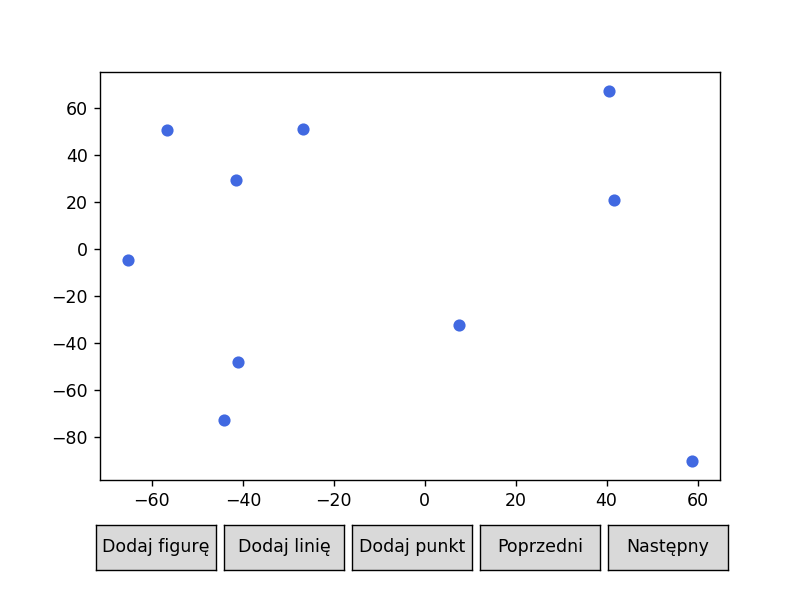

In [44]:
# Zadane zbiory punktów:


# Zbiór punktów 1
from random import uniform


T1 = [(uniform(-100,100), uniform(-100,100)) for _ in range(10)]

plot = Plot(points=[PointsCollection(T1, color = 'royalblue')])
plot.draw()


<IPython.core.display.Javascript object>


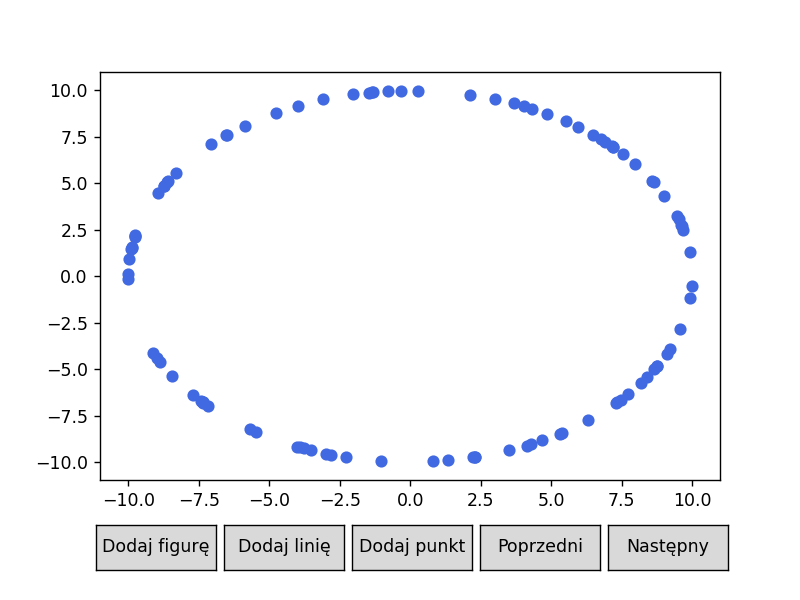

In [45]:
# Zbiór punktów 2
from math import pi
from math import sin
from math import cos

circle = [(0.0, 0.0) for _ in range(100)]
for i in range(100):
    alfa = uniform(0, 2 * pi)
    circle[i] = (10 * cos(alfa), 10 * sin(alfa))
    
plot = Plot(points=[PointsCollection(circle, color = 'royalblue')])
plot.draw()

<IPython.core.display.Javascript object>


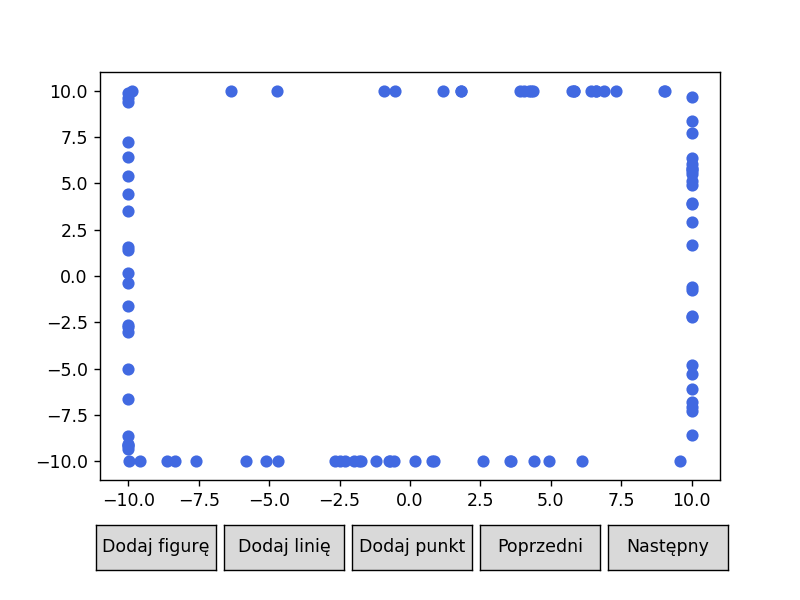

In [46]:
# Zbiór punktów 3
from random import randint

rectangle = [(0.0, 0.0) for _ in range(100)]
for i in range(100):
    r = randint(1, 4)
    x = uniform(-10, 10)
    y = uniform(-10, 10)
    
    if r == 1:
        x = -10.0
    elif r == 2:
        x = 10.0
    elif r == 3:
        y = -10.0
    else:
        y = 10.0
    
    rectangle[i] = (x, y)

plot = Plot(points=[PointsCollection(rectangle, color = 'royalblue')])
plot.draw()

<IPython.core.display.Javascript object>


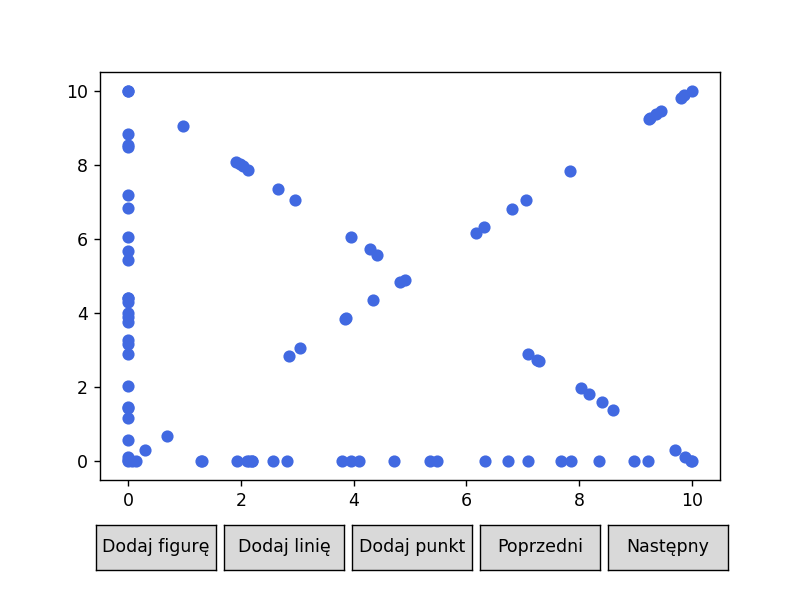

In [47]:
# Zbiór punktów 4
square = [(0.0, 0.0) for _ in range(94)]
square[0] = (0.0, 0.0)
square[1] = (0.0, 10.0)
square[2] = (10.0, 10.0)
square[3] = (10.0, 0.0)
f = 4

x = 0
y = 0
for i in range (f, f + 25):
    y = uniform(0, 10)
    square[i] = (x, y)

f += 25
y = 0
for i in range (f, f + 25):
    x = uniform(0, 10)
    square[i] = (x, y)

f += 25
for i in range(f, f + 20):
    x = uniform(0, 10)
    y = x
    square[i] = (x, y)

f += 20
for i in range(f, f + 20):
    x = uniform(0, 10)
    y = 10 - x
    square[i] = (x, y)


plot = Plot(points=[PointsCollection(square, color = 'royalblue')])
plot.draw()

In [49]:
# Generowanie zbiorów o własnych parametrach

# Zbiór punktów 1
from random import uniform

def random_points(n, a, b):
    T = [(uniform(a,b), uniform(a,b)) for _ in range(n)]
    
    return T

In [50]:
# Zbiór punktów 2
from math import pi
from math import sin
from math import cos

def random_circle(n, o, r):
    circle = [o for _ in range(n)]
    for i in range(n):
        alfa = uniform(0, 2 * pi)
        circle[i] = (r * cos(alfa), r * sin(alfa))
        
    return circle

In [51]:
# Zbiór punktów 3
from random import randint

# w kolejności a - lewy górny, b - lewy dolny, c - prawy dolny, d - prawy górny
def random_rectangle(n, a, b, c ,d):
    rectangle = [(0.0, 0.0) for _ in range(n)]
    for i in range(n):
        r = randint(1, 4)
        x = uniform(b[0], d[0])
        y = uniform(b[1], d[1])

        if r == 1:
            x = b[0]
        elif r == 2:
            x = d[0]
        elif r == 3:
            y = b[1]
        else:
            y = d[1]

        rectangle[i] = (x, y)
    
    return rectangle

In [52]:
# Zbiór punktów 4

# w kolejności a - lewy górny, b - lewy dolny, c - prawy dolny, d - prawy górny
# na - ilość punktów na osiach, nd - ilość punktów na przekątnych

def random_square(a, b, c, d, na, nd):
    square = [(0.0, 0.0) for _ in range(4 + (2 * na) + (2 * nd))]
    square[0] = a
    square[1] = b
    square[2] = c
    square[3] = d
    f = 4

    x = 0
    y = 0
    for i in range (f, f + na):
        y = uniform(b[1], d[1])
        square[i] = (x, y)

    f += na
    y = 0
    for i in range (f, f + na):
        x = uniform(b[0], d[0])
        square[i] = (x, y)

    f += na
    for i in range(f, f + nd):
        x = uniform(b[0], d[0])
        y = x
        square[i] = (x, y)

    f += nd
    for i in range(f, f + nd):
        x = uniform(b[0], d[0])
        y = 10 - x
        square[i] = (x, y)
        
    return square

<IPython.core.display.Javascript object>


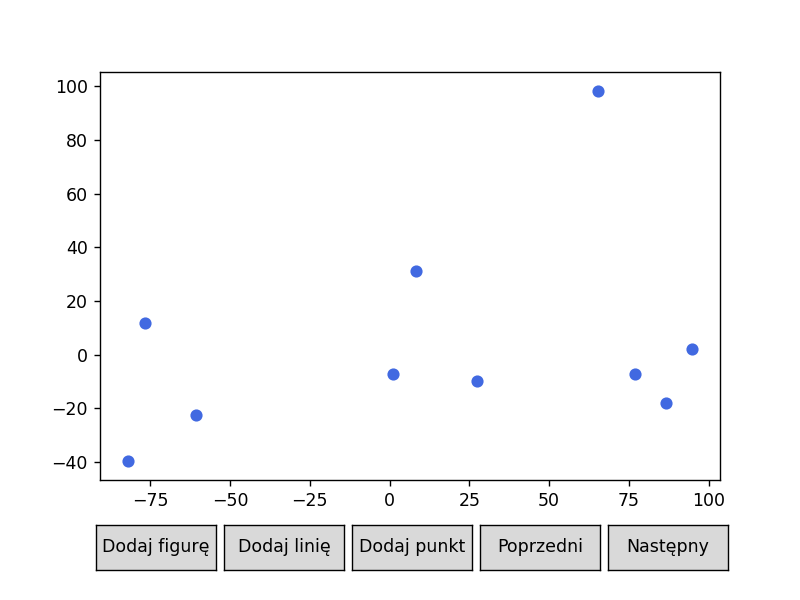

In [53]:
# Miejsce na stworzenia i narysowanie dowolnego zbioru punktów

#T = random_square((0, 0), (10, 0), (10, 10), (0, 10), 250, 200)
#T = random_rectangle(100, (-10, 10), (-10, -10), (10, -10), (10, 10))
#T = random_circle(100, (0, 0), 10)
T = random_points(10, -100, 100)

plot = Plot(points=[PointsCollection(T, color = 'royalblue')])
plot.draw()

In [54]:
# Tolerancja
tol = 10**-12

In [55]:
#Obliczanie wyznaczników

def orient(a, b, c):
    det = a[0] * b[1] + a[1] * c[0] + b[0]*c[1] - (b[1] * c[0] + a[0] * c[1] + a[1] * b[0])
    if det > tol:
        return 1
    if det < -tol:
        return -1
    return 0

In [56]:
from math import sqrt
def distance(a, b):
    return sqrt((b[0] - a[0])**2 + (b[1] - a[1])**2)

In [57]:
def compare(a, b, c, removed):
    x = orient(a, b, c)
    
    if orient(a, b, c) != 0:
        return orient(a, b, c)
    
    if distance(a, c) > distance(a, b):
        removed.append(b)
        return 1
    else:
        removed.append(c)
        return -1

In [58]:
def partition(A, p, r, a, removed):
    x = A[r]
    i = p - 1
    for j in range(p, r):
        if compare(a, x, A[j], removed) == -1:
            i += 1
            A[i], A[j] = A[j], A[i]
    A[i + 1], A[r] = A[r], A[i + 1]
    return i + 1

In [59]:
def quicksort(A, p, r, a, removed):
    while p < r:
        q = partition(A, p, r, a, removed)

        if (q - p) < (r - q):
            quicksort(A, p, q - 1, a, removed)
            p = q + 1
        else:
            quicksort(A, q + 1, r, a, removed)
            r = q - 1

<IPython.core.display.Javascript object>


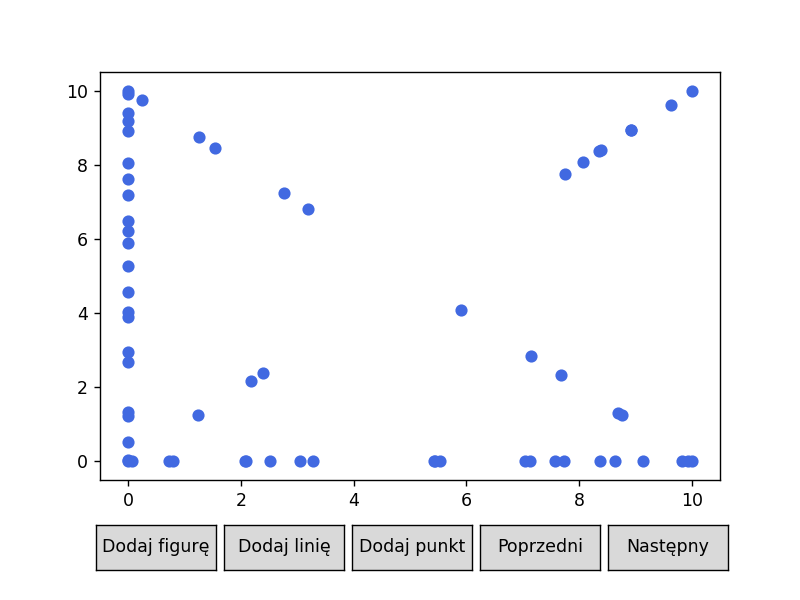

In [60]:
T = random_square((0, 0), (10, 0), (10, 10), (0, 10), 20, 10)
plot = Plot(points=[PointsCollection(T, color = 'royalblue')])
plot.draw()

In [61]:
def graham(A, visualise = True):
    T = A.copy()
    
    scenes = []
    removed = []
    mini = min(T, key = lambda x: (x[1], x[0]))
    T.remove(mini)

    quicksort(T, 0, len(T) - 1, mini, removed)
    T = [mini] + T
    removed = list(set(removed))
    
    for i in removed:
        T.remove(i)
    
    if visualise:
        scenes.append(Scene(points=[PointsCollection(removed, color = 'red'),
                                    PointsCollection(T)]))
    
        scenes.append(Scene(points=[PointsCollection(T)]))

    stack = [] 
    stack.append(T[0])
    stack.append(T[1])
    stack.append(T[2])
    i = 3

    if visualise:
        scenes.append(Scene([PointsCollection(T), PointsCollection([T[0], T[1]], color="springgreen")],
                                [LinesCollection([(T[0], T[1])], color="springgreen")]))

        scenes.append(Scene([PointsCollection(T), PointsCollection([T[0], T[1]], color="springgreen"), 
                                PointsCollection([T[2]], color="cyan")],
                                [LinesCollection([(T[0], T[1])], color="springgreen"), 
                                LinesCollection([(T[1], T[2])], color="cyan")]))

    while i < len(T):
        if visualise:
            scenes.append(Scene([PointsCollection(T), PointsCollection(stack.copy(), color="springgreen"), 
                                PointsCollection([T[i]], color="cyan")],
                                [LinesCollection([(stack[i], stack[i+1]) for i in range(len(stack)-1)], color="springgreen"), 
                                LinesCollection([(T[i], stack[-1])], color="cyan")]))

        if orient(stack[-2], stack[-1], T[i]) == 1:
            stack.append(T[i])
            i += 1
        elif orient(stack[-2], stack[-1], T[i]) == - 1:
            stack.pop()
        else:
            stack.pop()
            stack.append(T[i])
            i += 1

            
    if orient(stack[-2], stack[-1], mini) == 0:
        stack.pop()        
    
    if visualise:
        lines = [(stack[i], stack[i+1]) for i in range(len(stack)-1)]
        lines.append([stack[-1], stack[0]])

        final_scene = Scene([PointsCollection(T), PointsCollection(stack, color="springgreen")], [LinesCollection(lines, color="springgreen")])
        scenes.append(final_scene)        

    plot_graham = Plot(scenes)
    return stack, plot_graham

<IPython.core.display.Javascript object>


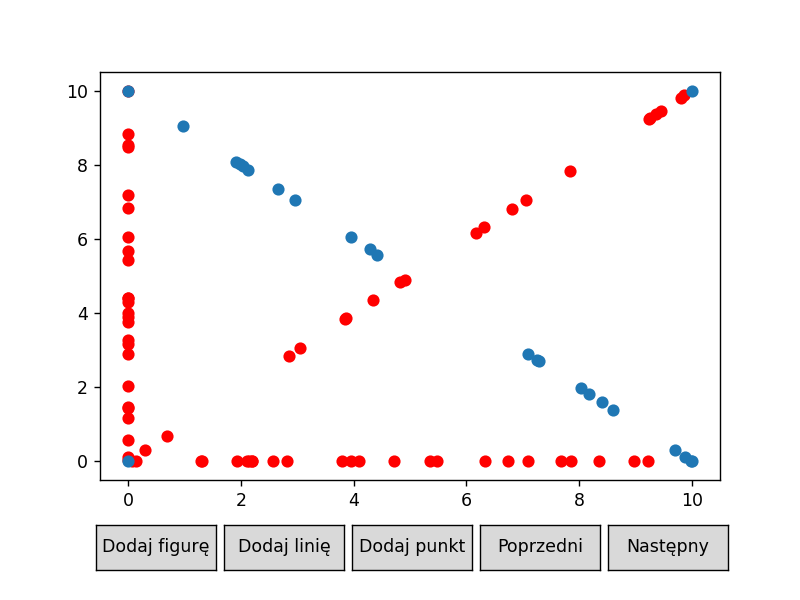

In [62]:
# 1. Zestaw danych:
plot = graham(square)[1]
plot.draw()

<IPython.core.display.Javascript object>


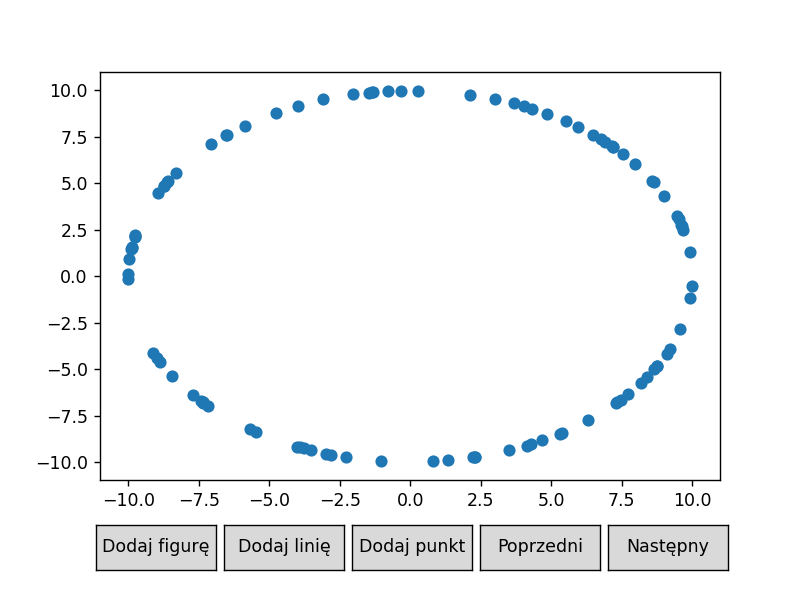

In [63]:
# 2. Zestaw danych:
plot = graham(circle)[1]
plot.draw()

<IPython.core.display.Javascript object>


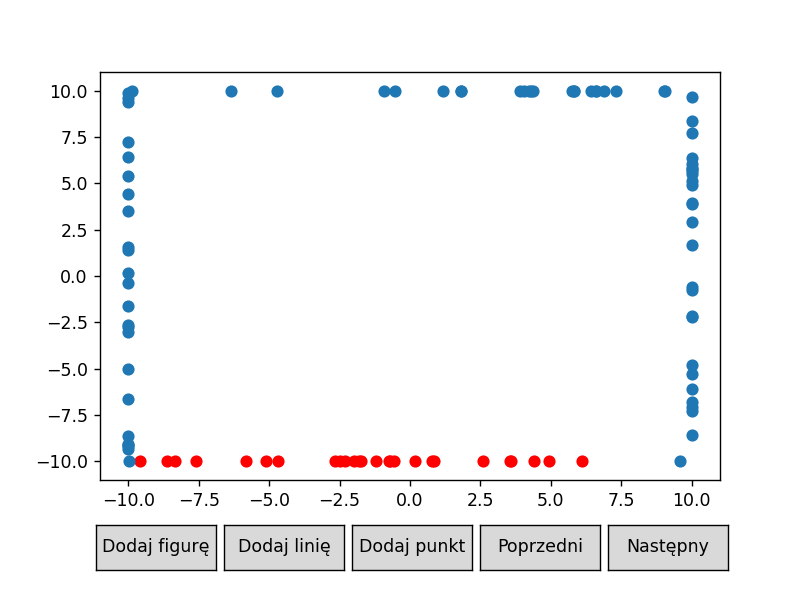

In [64]:
# 3. Zestaw danych:
plot = graham(rectangle)[1]
plot.draw()

<IPython.core.display.Javascript object>


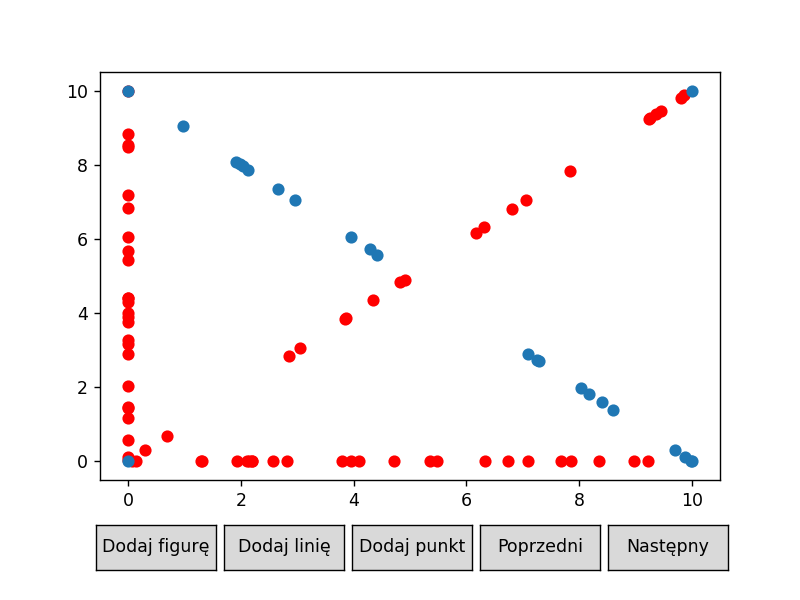

In [65]:
# 4. Zestaw danych:
plot = graham(square)[1]
plot.draw()

In [66]:
print(graham(square)[0])

[(0.0, 0.0), (10.0, 0.0), (10.0, 10.0), (0.0, 10.0)]


In [67]:
from math import inf
def jarvis(T, visualise = True):
    scenes = []
    mini = min(T, key = lambda x: (x[1], x[0]))
    
    i = mini
    result = [(mini[0] + 1, mini[1])]
    
    scenes.append(Scene([PointsCollection(T), PointsCollection([mini], color="springgreen")]))
    
    while True:
        result.append(i)
        smallest_angle = result[-2]
        for j in range(len(T)):
            if i == T[j]:
                continue
            if visualise:
                scenes.append(Scene([PointsCollection(T), PointsCollection(result[1:].copy(), color="springgreen"), 
                                PointsCollection([T[j]], color="cyan")],
                                [LinesCollection([(result[k], result[k+1]) for k in range(1, len(result)-1)], color="springgreen"), 
                                LinesCollection([(T[j], result[-1])], color="cyan")]))
            
            if compare(i,smallest_angle, T[j], []) == 1:
                smallest_angle = T[j]
        
        i = smallest_angle
        if i == mini:
            break
     
    if visualise:
        lines = [(result[k], result[k+1]) for k in range(1, len(result)-1)]
        lines.append([result[-1], result[1]])

        final_scene = Scene([PointsCollection(T), PointsCollection(result[1:].copy(), color="springgreen")], 
                            [LinesCollection(lines, color="springgreen")])
        scenes.append(final_scene)        
    
    result = result[1:]
    plot_jarvis = Plot(scenes)
    
    return result, plot_jarvis

<IPython.core.display.Javascript object>


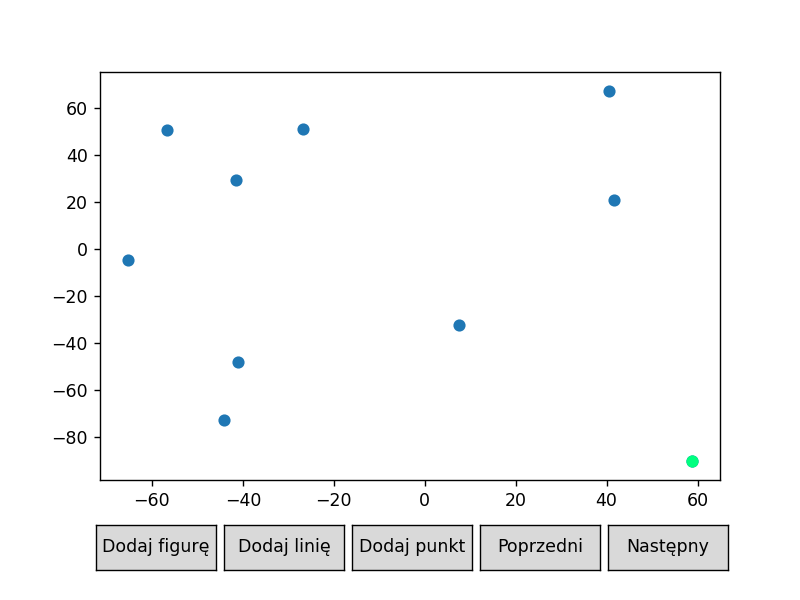

In [68]:
# 1. Zestaw danych:
plot = jarvis(T1)[1]
plot.draw()

<IPython.core.display.Javascript object>


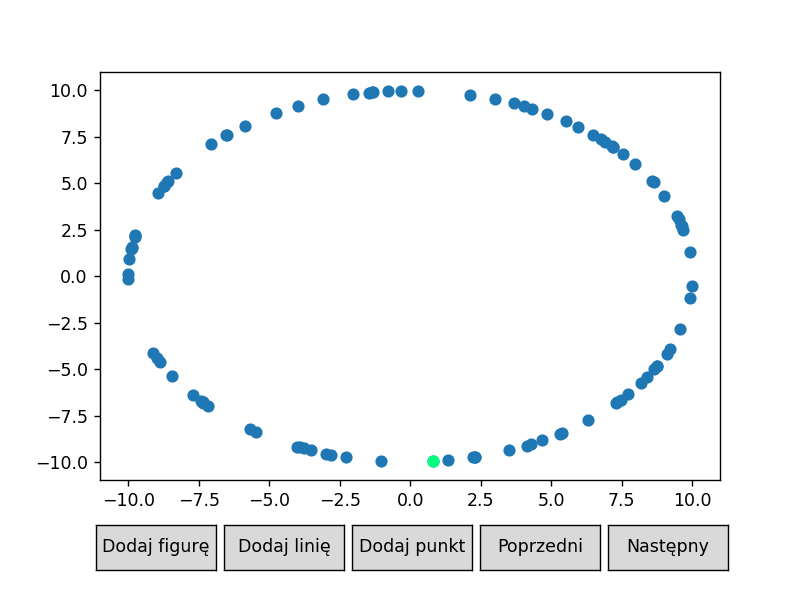

In [69]:
# 2. Zestaw danych:
plot = jarvis(circle)[1]
plot.draw()

<IPython.core.display.Javascript object>


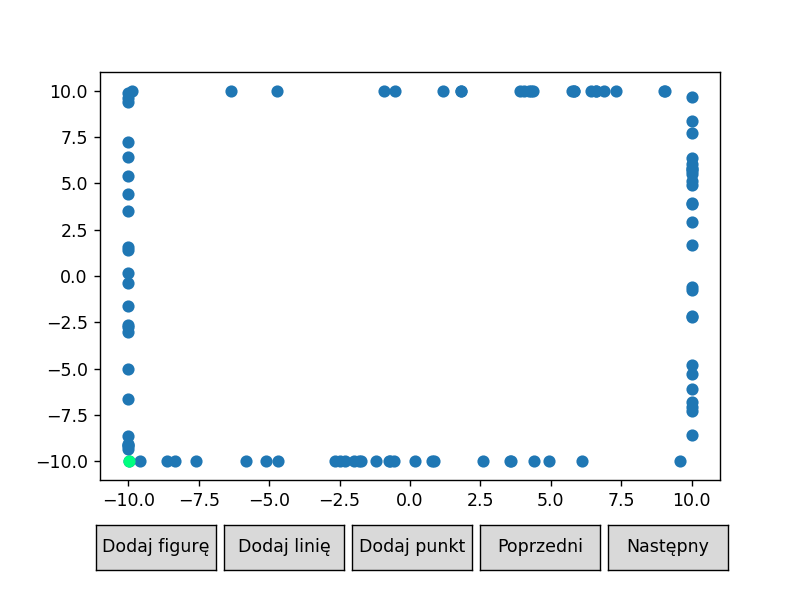

In [70]:
# 3. Zestaw danych:
plot = jarvis(rectangle)[1]
plot.draw()

<IPython.core.display.Javascript object>


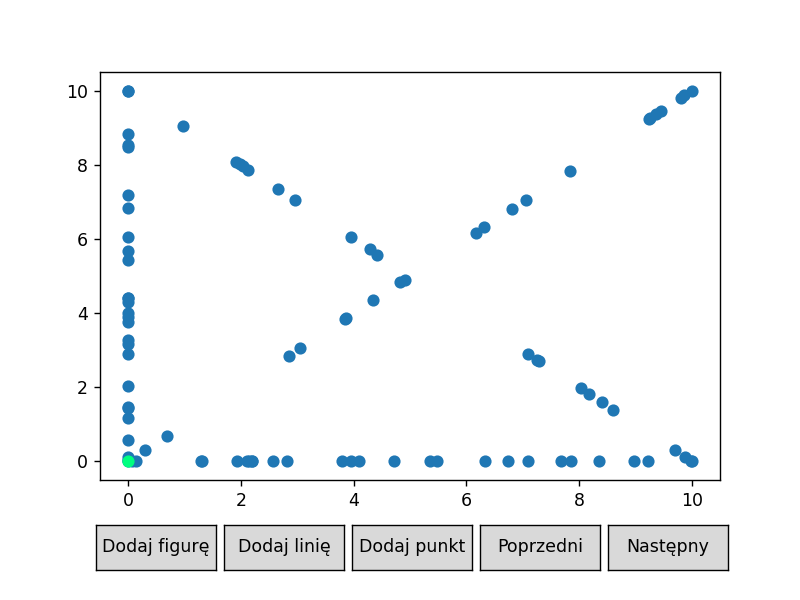

In [71]:
# 4. Zestaw danych:
plot = jarvis(square)[1]
plot.draw()

<IPython.core.display.Javascript object>


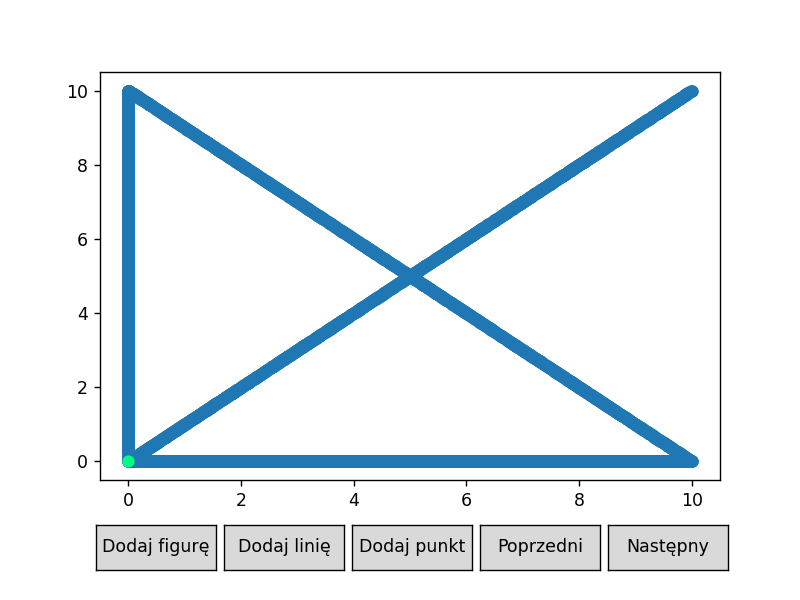

10000


In [74]:
A4 = random_square((0, 0), (10, 0), (10, 10), (0, 10), 2555, 2443)
plot = jarvis(A4)[1]
plot.draw()
print(len(A4))

In [76]:
from time import time
A4 = random_square((0, 0), (10, 0), (10, 10), (0, 10), 25555, 24443)
A3 = random_rectangle(100, (-10, 10), (-10, -10), (10, -10), (10, 10))
A2 = random_circle(1000, (0, 0), 10)
A1 = random_points(100, -100, 100)

print('Points:')
start = time()
graham(A1, False)
end = time()
print('Graham time: \t\t',end - start)
start = time()
jarvis(A1, False)
end = time()
print('Jarvis time: \t\t',end - start)


print('Circle:')
start = time()
graham(A2, False)
end = time()
print('Graham time: \t\t',end - start)
start = time()
jarvis(A2, False)
end = time()
print('Jarvis time: \t\t',end - start)


print('Rectangle:')
start = time()
graham(A3, False)
end = time()
print('Graham time: \t\t',end - start)
start = time()
jarvis(A3, False)
end = time()
print('Jarvis time: \t\t',end - start)

print('Square:')
start = time()
graham(A4, False)
end = time()
print('Graham time: \t\t',end - start)
start = time()
jarvis(A4, False)
end = time()
print('Jarvis time: \t\t',end - start)

Points:
Graham time: 		 0.001994609832763672
Jarvis time: 		 0.0009970664978027344
Circle:
Graham time: 		 0.01795220375061035
Jarvis time: 		 1.6246702671051025
Rectangle:
Graham time: 		 0.0009980201721191406
Jarvis time: 		 0.0019943714141845703
Square:


KeyboardInterrupt: 

In [77]:
def convex_hull_to_txt(convex_hull):
    with open('convex_hull.txt', 'w') as file:
        file.write("\n".join(str(point) for point in convex_hull))

In [78]:
convex_hull = graham(rectangle)[0]

convex_hull_to_txt(convex_hull)

In [79]:
convex_hull = jarvis(rectangle)[0]

convex_hull_to_txt(convex_hull)